In [1]:
import pandas as pd
import numpy as np
import ast
import matplotlib.pyplot as plt
import re
import folium
import seaborn as sn

import gensim
from gensim import corpora
import nltk
# nltk.download('stopwords')
from nltk.corpus import stopwords
stop = stopwords.words('english')
# import jellyfish
import pyLDAvis
pyLDAvis.enable_notebook()
import pyLDAvis.gensim_models

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score

import lightgbm
from sklearn import tree
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm

c:\Users\Immig\anaconda3\envs\dsba6211\lib\site-packages\past\builtins\misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload


In [2]:
df = pd.read_parquet('../_df_for_modeling.parquet')
def data_cleanup(df):

    df.dropna(how='all', axis=1, inplace=True) #drop empty cols

    number_looking_strings = ['id', 'scrape_id', 'host_id']
    for col in number_looking_strings:
        df[col] = df[col].astype("string")

    df['host_response_rate'] = df['host_response_rate'].str.replace("%","").astype(float)/100 #previously a percentage as a string
    df['host_acceptance_rate'] = df['host_acceptance_rate'].str.replace("%","").astype(float)/100 #previously a percentage as a string
    df['price'] = df['price'].str.replace(r'[$,]',"").astype(float) #previosuly represented as a string

    date_cols = ['last_scraped', 'host_since', 'calendar_last_scraped', 'first_review', 'last_review']
    for col in date_cols:
        df[col] = pd.to_datetime(df[col], format=r'%Y-%m-%d')

    for col in df.columns:
        if df[col][0] == "f" or df[col][0] == "t": #if first record is "t" or "f" we're going to convert to bool - still should spot check after just incase first record of bool is null
            df[col] = df[col].str.replace("f", "0")
            df[col] = df[col].str.replace("t", "1")
            try: ## int can't hold nulls so if the conversion fails due to a value error, convert to float instead
                df[col] = df[col].astype(int)
            except:
                df[col] = df[col].astype(float)


    remaining_string_cols = df.select_dtypes(include=["object"]).columns #all remaining object columns are strings so I'm explicitly setting them to be
    for col in remaining_string_cols:
        df[col] = df[col].astype('string')

    list_string_cols = ['host_verifications', 'amenities'] #these 2 columns are string lists so I'm converting them back to object just so I remember to handle them differently
    for col in list_string_cols:
        df[col] = df[col].astype('object')

    return df

df = data_cleanup(df)

C:\Users\Immig\AppData\Local\Temp\ipykernel_13644\2129636235.py:12: FutureWarning: The default value of regex will change from True to False in a future version.
  df['price'] = df['price'].str.replace(r'[$,]',"").astype(float) #previosuly represented as a string


In [3]:
# df['amenities'] = df['amenities'].apply(lambda x: ast.literal_eval(x))

# test = []
# for i in np.arange(len(df['amenities'])):
#     for j in np.arange(len(df['amenities'][i])):
#         test.append(df['amenities'][i][j])

# len(test)

# test2 = pd.Series(test).unique()
# len(test2)


# test2 = pd.Series(test2)
# test2.apply(lambda x: 1 if "tv" in x.lower() else 0).sum()

In [4]:
df['amenities'] = df['amenities'].apply(lambda x: ast.literal_eval(x))
df['amenities'] = df['amenities'].apply(lambda x: ' '.join(x))
df['amenities'] = df['amenities'].apply(lambda x: x.lower())

# no stemming, but remove stop words and special characters
df['amenities'] = df['amenities'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
df['amenities'] = df['amenities'].apply(lambda x:" ".join(re.findall(r'[\w]+',x)))


corpus = [lst.split() for lst in df['amenities']]
dictionary = corpora.Dictionary(corpus)
DFM = [dictionary.doc2bow(word_lst) for word_lst in corpus]


n_topics = 4
ldamodel = gensim.models.LdaMulticore(DFM,
                                    num_topics = n_topics,
                                    id2word = dictionary,
                                    passes = 20,
                                    workers=12,
                                    random_state=902)

lda_topic_assignment = [max(x,key=lambda item: item[1]) for x in ldamodel[DFM]]


vis = pyLDAvis.gensim_models.prepare(ldamodel,
                                     DFM,
                                     dictionary)


# add as a new feature to the df
df['amenity_topic'] = [val[0] for val in lda_topic_assignment]
df['amenity_topic'] = df['amenity_topic'].astype('string')
df.drop(columns=['amenities'], inplace=True)

vis

c:\Users\Immig\anaconda3\envs\dsba6211\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.077990 -0.031234       1        1  40.235733
3     -0.081282 -0.052664       2        1  40.196068
1     -0.077184  0.054526       3        1  10.726561
0      0.080476  0.029373       4        1   8.841639, topic_info=       Term          Freq         Total Category  logprob  loglift
2     alarm  12057.000000  12057.000000  Default  30.0000  30.0000
72       tv   7387.000000   7387.000000  Default  29.0000  29.0000
24    dryer  11769.000000  11769.000000  Default  28.0000  28.0000
54  parking   9865.000000   9865.000000  Default  27.0000  27.0000
32     free  12526.000000  12526.000000  Default  26.0000  26.0000
..      ...           ...           ...      ...      ...      ...
62  shampoo    539.554263   6040.725053   Topic4  -4.3896   0.0102
46     long    539.088076   6014.345259   Topic4  -4.3905   0.0137
71     term    534.460915   6014.386106   Topic4  -4.3991   0.0050
68    stays    533.639487   6014.837298   Topic4  -4.4006   0.0034
37  hangers    532.956145   5956.993761   Topic4  -4.4019   0.0118

[307 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
268       2  0.016573      0
268       3  0.977800      0
273       2  0.027825     10
273       3  0.959974     10
428       1  0.670315    112
...     ...       ...    ...
954       3  0.888256  works
546       2  0.957292   year
546       3  0.033010   year
256       2  0.019420  years
256       3  0.980714  years

[613 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 4, 2, 1])

In [5]:
df['host_tenure'] = (df['last_scraped']-df['host_since']).dt.days
# some listings have no value for host_since leading to a null for host_tenure. Replace these with 0
df['host_tenure'] = df['host_tenure'].fillna(0).astype(int)

# Change host_location to be a binary, nashville or not nashville
df['host_location'] = df['host_location'].fillna(' ').apply(lambda x: 1 if "nashville" in x.lower() else 0) # host location is now a binary (1 if host is in Nashville, else 0)

In [6]:
#drop columns with primarily unique values - this will take care of things like ids, urls, descriptions, etc
drop_list = []
string_cols = df.select_dtypes(include=["object","string"]).columns
for col in string_cols:
    if len(df[col].value_counts()) > 1000:
        drop_list.append(col)

print(drop_list, "getting dropped.")
df.drop(columns=drop_list, inplace=True)


#also drop neighborhood because there's a cleansed column with this
df.drop(columns=['neighbourhood'], inplace=True)

#also drop price as the feature 'avg_price' replaces it
df.drop(columns=['price'], inplace=True)

droplist = ['host_listings_count', 'calculated_host_listings_count', 'calculated_host_listings_count_entire_homes',
 'calculated_host_listings_count_private_rooms', 'calculated_host_listings_count_shared_rooms']
 
df.drop(columns=droplist, inplace=True)

['id', 'listing_url', 'name', 'description', 'neighborhood_overview', 'picture_url', 'host_id', 'host_url', 'host_name', 'host_about', 'host_thumbnail_url', 'host_picture_url'] getting dropped.


In [7]:
#drop dep_candidate and all variables similar to what was used to create it
drop_cols = []
for col in df.columns:
    if "review" in col:
        drop_cols.append(col)
    if "availability" in col:
        drop_cols.append(col)
    # if "host" in col:
    #     drop_cols.append(col)
drop_cols.append("scrape_id") # not relevant
drop_cols.append("last_scraped") # used for host tenure calculation
drop_cols.append("host_since") # captured in host tenure
drop_cols.append("calendar_last_scraped") # used for host tenure calculation
print(drop_cols, "getting dropped")
df.drop(columns=drop_cols, inplace=True)

['has_availability', 'availability_30', 'availability_60', 'availability_90', 'availability_365', 'number_of_reviews', 'number_of_reviews_ltm', 'number_of_reviews_l30d', 'first_review', 'last_review', 'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value', 'reviews_per_month', 'scrape_id', 'last_scraped', 'host_since', 'calendar_last_scraped'] getting dropped


In [8]:
df.select_dtypes(include=["object","string"]).describe(include='all')

host_response_time host_neighbourhood  host_verifications  \
count                6538               4897                6863   
unique                  4                239                  90   
top        within an hour           Downtown  ['email', 'phone']   
freq                 6084                563                4638   

       neighbourhood_cleansed property_type        room_type bathrooms_text  \
count                    6863          6863             6863           6861   
unique                     35            54                4             32   
top               District 19   Entire home  Entire home/apt         1 bath   
freq                     1716          2282             6256           2472   

       amenity_topic  
count           6863  
unique             4  
top                2  
freq            3587

In [9]:
df.drop(columns=['host_neighbourhood'], inplace=True)
df.drop(columns=['host_verifications'], inplace=True)
df.drop(columns=['property_type'], inplace=True)

In [10]:
df['neighbourhood_cleansed'] = df['neighbourhood_cleansed'].str.replace('District ', '')
df.rename(columns={'neighbourhood_cleansed':'district'},inplace=True)

In [11]:
df['bathrooms_text'].value_counts()

def clean_bathrooms(x):
    words = x.split()
    values= []
    for word in words:
        try:
            values.append(float(word))
        except:
            values.append(0)
    
    if x == "Half-bath":
        val = "1"
    elif max(values) == 0:
        val = "0"
    elif max(values) == 1:
        val = "1"
    elif max(values) <= 3:
        val = "2-3"
    else:
        val = ">3"
    
    if "shared" in x:
        val = "shared"
    
    return val

df['bathrooms_text'] = df['bathrooms_text'].fillna("-1").apply(clean_bathrooms)
df.rename(columns={'bathrooms_text':'baths'},inplace=True)


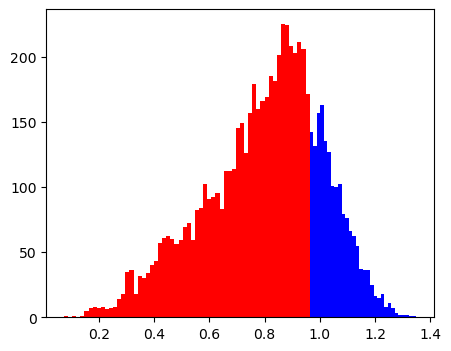

In [12]:
#dep_var_cutoff = df['dep_candidate'].mean()
dep_var_cutoff = df['dep_candidate'].quantile(0.75)
df['dep_candidate_cutoff_bool'] = (df['dep_candidate'] >= dep_var_cutoff).astype(int)
fig = plt.figure(figsize=(5,4))
plt.hist(df[df['dep_candidate']<=dep_var_cutoff][['dep_candidate']], bins=60, color='red')
plt.hist(df[df['dep_candidate']>dep_var_cutoff][['dep_candidate']], bins=30, color='blue')
plt.show()
df.drop(columns=['dep_candidate'], inplace=True)

In [13]:
listings_1 = df[df["dep_candidate_cutoff_bool"]==1][["latitude", "longitude"]]
listings_0 = df[df["dep_candidate_cutoff_bool"]==0][["latitude", "longitude"]]


f = folium.Figure(width=800, height=600)
map = folium.Map(location=[df['latitude'].quantile(0.5), 
                        df['longitude'].quantile(0.5)],
                        zoom_start=11, 
                        control_scale=True,
                        tiles="cartodbpositron",
                        width=800, height=600).add_to(f)

for index, rowdata in listings_0.iterrows():
    folium.CircleMarker([rowdata["latitude"], rowdata["longitude"]],
                        radius=1, fill=False,
                        color = '#ff0f0f75').add_to(map) #red
for index, rowdata in listings_1.iterrows():
    folium.CircleMarker([rowdata["latitude"], rowdata["longitude"]],
                        radius=1, fill=False,
                        color = '#0202f075').add_to(map) # blue

map

In [14]:
# Impute missing values using mode for categorical columns and median for numerical columns
cat_columns = df.select_dtypes(include=["string","object"]).columns
num_columns = df.select_dtypes(include="number").columns

# Replace missing values in the categorical columns with the most frequent value
for col in cat_columns:
        df[col].fillna("⍼", inplace=True)

# Replace missing values in the numerical columns with the median value
for col in num_columns:
    df[col].fillna(df[col].mean(), inplace=True)

# Separate target variable and feature columns
target = df["dep_candidate_cutoff_bool"]
features = df.drop(["dep_candidate_cutoff_bool"], axis=1)


features = pd.get_dummies(features, drop_first=True)

In [15]:
features = features.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

In [16]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state = 999)

In [17]:
cv = StratifiedKFold(n_splits=4, shuffle=True, random_state = 999)
# Define tree model and model parameters to evalaute
params = {'criterion': ['entropy', 'gini'], 'max_depth': list(np.arange(3,12,1)), 
            'min_samples_split': list(np.arange(5,33,3))}
model_dtree = tree.DecisionTreeClassifier()

gscv_dtree = GridSearchCV(estimator=model_dtree, param_grid=params, verbose=1, 
                            cv=cv, n_jobs=-1, scoring='roc_auc', refit=True).fit(X_train, y_train)

# y_pred_dtree = gscv_dtree.predict_proba(X_test)
# print('roc_auc:', roc_auc_score(y_test, y_pred_dtree[:,1]))

print(gscv_dtree.best_params_)
print('Decision tree AUC-score:', round(gscv_dtree.score(X_test, y_test),4))
print(' ')



# Train a LightGBM model on the training data
model_lgbm = lightgbm.LGBMClassifier()
params = {'max_bin': [128, 255, 512], 'max_depth': list(np.arange(3,12,1)),
            'min_data_in_leaf': list(np.arange(5,51,4))}
gscv_lgbm = GridSearchCV(estimator=model_lgbm, param_grid=params, verbose=1, 
                            cv=cv, n_jobs=-1, scoring='roc_auc', refit=True).fit(X_train, y_train)


# Evaluate the performance of the model
# print(classification_report(y_test, y_pred, digits=5))
print(gscv_lgbm.best_params_)
print('LGBM AUC-score:', round(gscv_lgbm.score(X_test, y_test),4))

Fitting 4 folds for each of 180 candidates, totalling 720 fits
{'criterion': 'entropy', 'max_depth': 6, 'min_samples_split': 23}
Decision tree AUC-score: 0.8213
 
Fitting 4 folds for each of 324 candidates, totalling 1296 fits
[LightGBM] [Warning] min_data_in_leaf is set=49, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=49
{'max_bin': 255, 'max_depth': 5, 'min_data_in_leaf': 49}
LGBM AUC-score: 0.8647


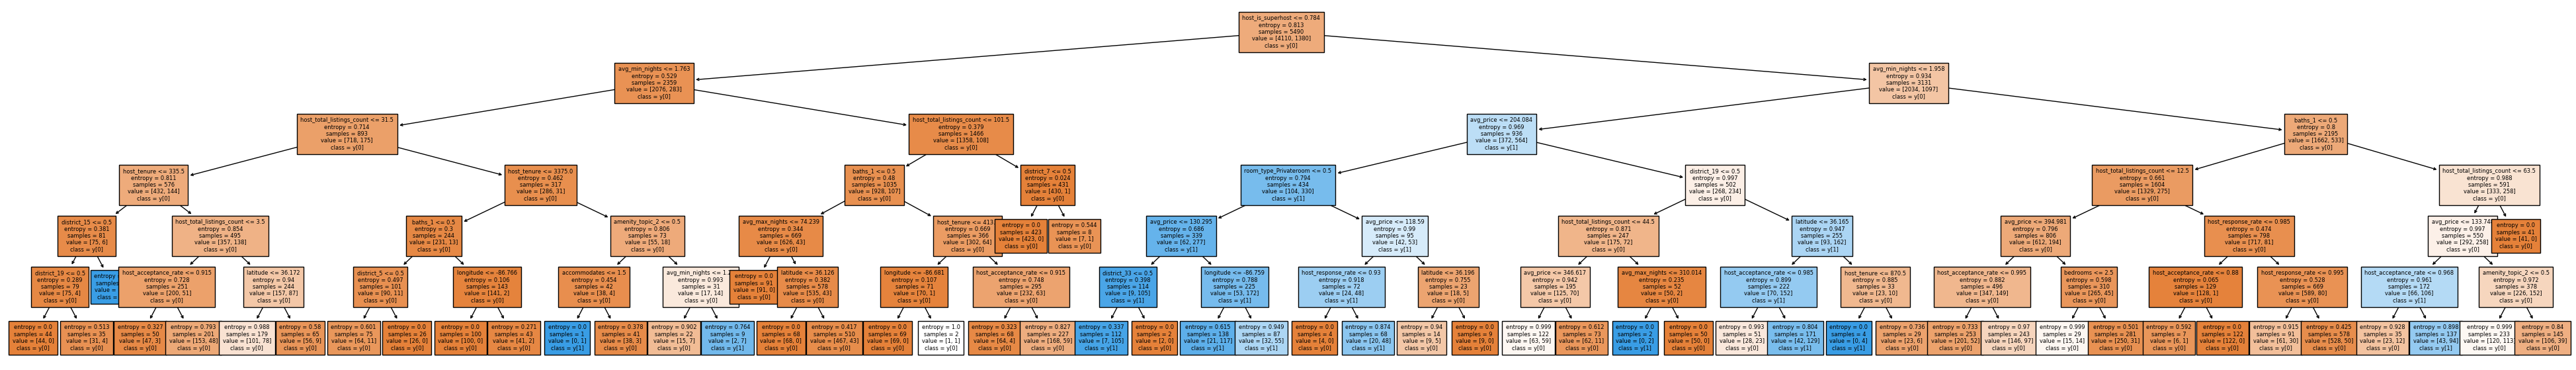

In [29]:
# refit tree on entire train with the best parameters
refit_dtree = tree.DecisionTreeClassifier(criterion = gscv_dtree.best_params_['criterion'],
                                            max_depth = gscv_dtree.best_params_['max_depth'],
                                            min_samples_split =gscv_dtree.best_params_['min_samples_split'])
refit_dtree.fit(X_train, y_train)

plt.figure(figsize=[50,7])
tree.plot_tree(refit_dtree,
               proportion=False,
               feature_names=list(features.columns.values),
               class_names=True,
               filled=True,
               fontsize=6)
plt.show()

Decision tree AUC-score: 0.799


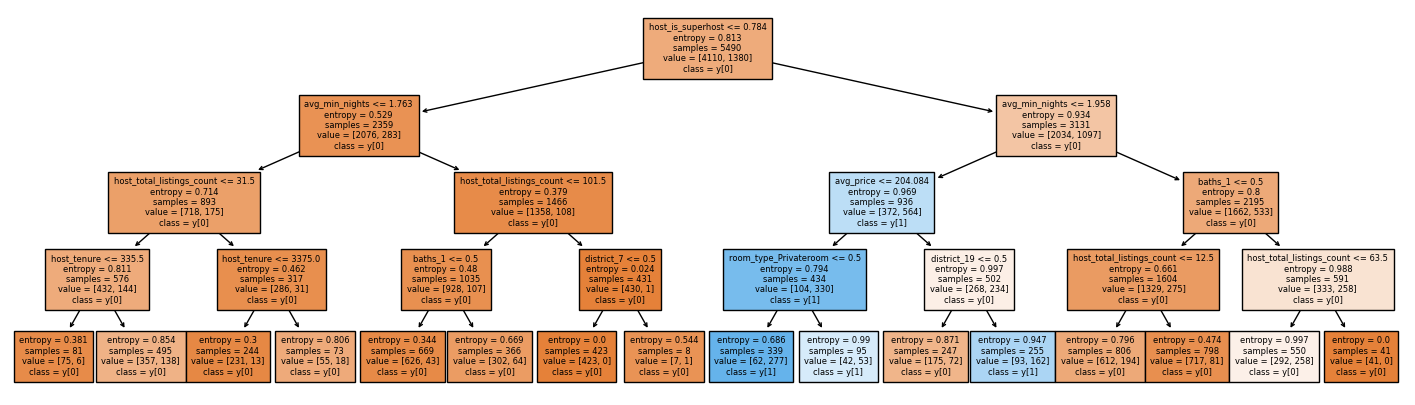

In [32]:
# refit tree on entire train with the best parameters
shallowe_dtree = tree.DecisionTreeClassifier(criterion = gscv_dtree.best_params_['criterion'],
                                            max_depth = 4,
                                            min_samples_split =gscv_dtree.best_params_['min_samples_split'])
shallowe_dtree.fit(X_train, y_train)
print('Decision tree AUC-score:', round(shallowe_dtree.score(X_test, y_test),4))

plt.figure(figsize=[18,5])
tree.plot_tree(shallowe_dtree,
               proportion=False,
               feature_names=list(features.columns.values),
               class_names=True,
               filled=True,
               fontsize=6)
plt.show()

In [1495]:
# Train a LightGBM model on the training data
model_lgbm = lightgbm.LGBMClassifier(max_bin = gscv_lgbm.best_params_['max_bin'],
                                     max_depth = gscv_lgbm.best_params_['max_depth'], 
                                     min_data_in_leaf = gscv_lgbm.best_params_['min_data_in_leaf'])
model_lgbm.fit(X_train, y_train)

# Make predictions on the test data
y_pred_lgbm = model_lgbm.predict_proba(X_test)

# Evaluate the performance of the model
# print(classification_report(y_test, y_pred, digits=5))
print('roc_auc:', round(roc_auc_score(y_test, y_pred_lgbm[:,1]),4))

[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
roc_auc: 0.8732


<AxesSubplot: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

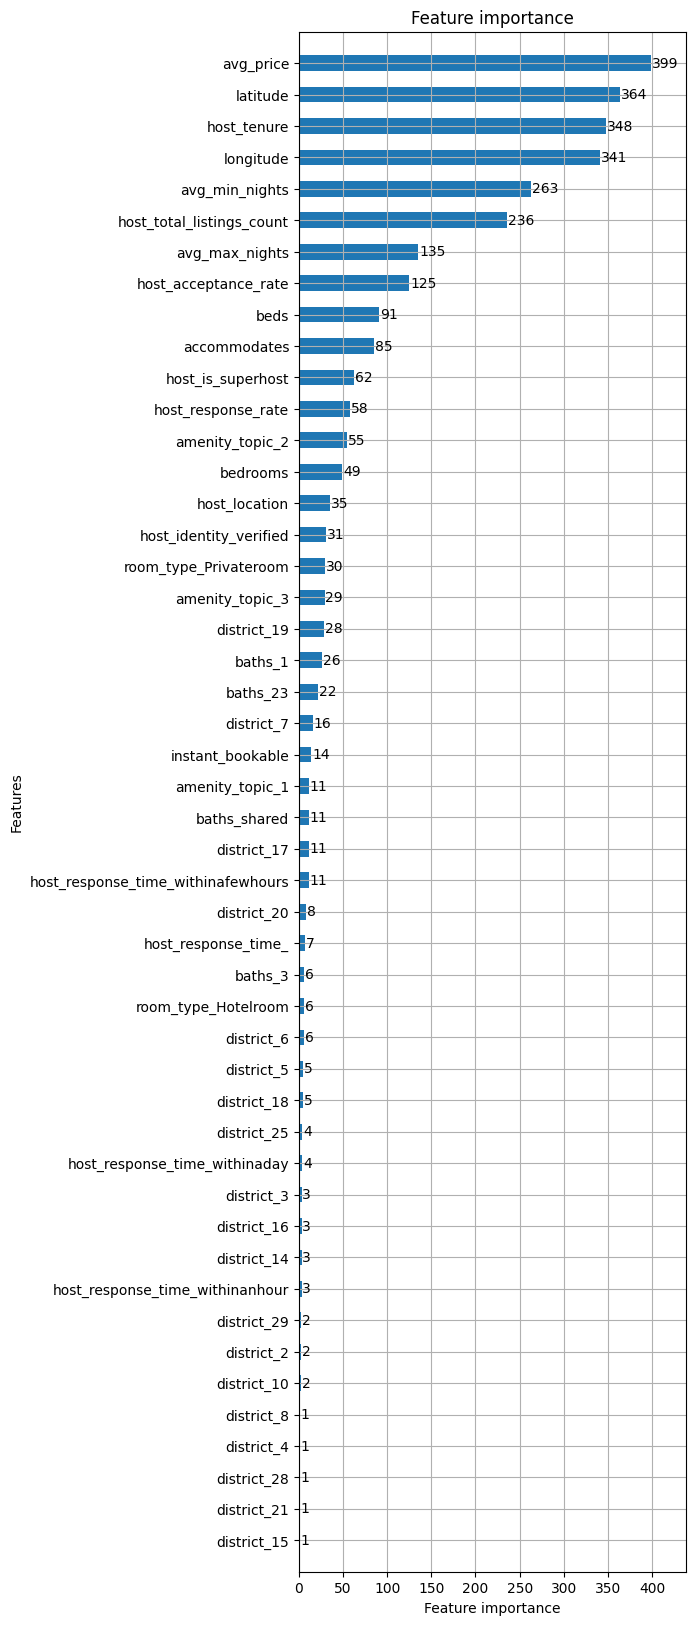

In [1496]:
plt.rcParams['figure.figsize'] = (5,20)
lightgbm.plot_importance(model_lgbm, height=0.5)

In [1497]:
check_vif_columns = df.select_dtypes(include=["number"]).columns

vif = [float(variance_inflation_factor(df[check_vif_columns].values,i)) for i in range(len(df[check_vif_columns].columns))]
vif_df = pd.DataFrame({"feature":df[check_vif_columns].columns, "VIF":vif})
vif_df


feature            VIF
0               host_location       3.536526
1          host_response_rate     297.805313
2        host_acceptance_rate     117.668019
3           host_is_superhost       2.956460
4   host_total_listings_count       1.111138
5        host_has_profile_pic     863.008641
6      host_identity_verified       7.173698
7                    latitude  576432.313623
8                   longitude  578125.482000
9                accommodates      23.689638
10                   bedrooms      14.824699
11                       beds       9.123089
12           instant_bookable       3.206239
13                  avg_price       9.271164
14             avg_min_nights      10.554134
15             avg_max_nights       4.257388
16                host_tenure       5.800826
17  dep_candidate_cutoff_bool       1.637893

In [1498]:
# drop variables with VIF > 11 1-by-1 (keeping avg_min_nights for now)
df_lr = df.copy()

while True:

    if vif_df.sort_values(by='VIF', ascending=False).iloc[0,1] > 11:
        df_lr.drop(columns=[vif_df.sort_values(by='VIF', ascending=False).iloc[0,0]], inplace=True)

        check_vif_columns = df_lr.select_dtypes(include=["number"]).columns
        vif = [float(variance_inflation_factor(df_lr[check_vif_columns].values,i)) for i in range(
                len(df_lr[check_vif_columns].columns))]
        vif_df = pd.DataFrame({"feature":df_lr[check_vif_columns].columns, "VIF":vif})
    else:
        break

vif_df

feature       VIF
0               host_location  3.404291
1           host_is_superhost  2.868211
2   host_total_listings_count  1.093846
3      host_identity_verified  6.039329
4                        beds  3.688127
5            instant_bookable  2.665277
6                   avg_price  6.761812
7              avg_min_nights  7.025537
8              avg_max_nights  3.953010
9                 host_tenure  5.510960
10  dep_candidate_cutoff_bool  1.573145

In [1499]:
# corrMatrix = df_lr[check_vif_columns].corr()
# def gen_corr_heatmapvalues(x):
#     exponent = 3
#     if x == 1:  
#         return 0        
#     else:
#         return x*abs(x)**exponent

# corrMatrix_hmapval = corrMatrix.applymap(gen_corr_heatmapvalues)
# z = corrMatrix_hmapval/corrMatrix
# zz = z.max().max()

# plt.figure(figsize=(4,4))
# palplot = sn.diverging_palette(150, 275, s=100, l=45, n=19)

# sn.heatmap(corrMatrix_hmapval, vmin=-zz, vmax=zz, annot=corrMatrix, cmap=palplot, cbar=None)
# plt.show()

In [1500]:
# get dummies
df_lr = pd.get_dummies(df_lr, drop_first=True)
df_lr = df_lr.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

# drop extremely imbalanced dummy features
droplist = []
for col in df_lr.columns:
    if (df_lr[col].mean() < 0.03) & (df_lr[col].mean() >= 0):
        droplist.append(col)

print(droplist)
df_lr.drop(columns=droplist,inplace=True)



# Separate target variable and feature columns
# already have target from before
features_lr = df_lr.drop(["dep_candidate_cutoff_bool"], axis=1)


# Split the data into training and testing sets
X_train_lr, X_test_lr, y_train_lr, y_test_lr = train_test_split(features_lr, target, test_size=0.2, random_state = 999)

['host_response_time_withinaday', 'district_10', 'district_11', 'district_12', 'district_13', 'district_14', 'district_16', 'district_20', 'district_22', 'district_23', 'district_24', 'district_25', 'district_26', 'district_27', 'district_28', 'district_29', 'district_3', 'district_30', 'district_31', 'district_32', 'district_33', 'district_34', 'district_35', 'district_4', 'district_8', 'district_9', 'room_type_Hotelroom', 'room_type_Sharedroom', 'baths_shared']


In [1501]:
# features_lr.hist(figsize=(25,20),bins=20)

In [1502]:
model_lr = sm.Logit(y_train_lr, X_train_lr).fit()
print(model_lr.summary())

Optimization terminated successfully.
         Current function value: 0.430408
         Iterations 8
                               Logit Regression Results                              
Dep. Variable:     dep_candidate_cutoff_bool   No. Observations:                 5490
Model:                                 Logit   Df Residuals:                     5461
Method:                                  MLE   Df Model:                           28
Date:                       Sat, 10 Dec 2022   Pseudo R-squ.:                  0.2366
Time:                               14:18:12   Log-Likelihood:                -2362.9
converged:                              True   LL-Null:                       -3095.4
Covariance Type:                   nonrobust   LLR p-value:                2.182e-291
                                         coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
host

In [1503]:
# Remove the insignificant features and train the model again. Accept p < 0.1 first, then 0.05
p_thres = 0.1

while True:
    logit_pvalues = round(model_lr.pvalues,3)

    if max(logit_pvalues) > p_thres:

        high_pval_col = logit_pvalues.index[logit_pvalues > 0.1]

        # Drop these columns
        features_lr = features_lr.drop(columns = high_pval_col)
        # print(f'The columns remaining after removing insignificant ones : {df_lr.shape}')
        X_train_lr, X_test_lr, y_train_lr, y_test_lr = train_test_split(features_lr, target, test_size=0.2, random_state = 999, stratify=target)

        # Model
        model_lr = sm.Logit(y_train_lr, X_train_lr).fit()
    else:
        p_thres = 0.05

        if max(logit_pvalues) > p_thres:
            high_pval_col = logit_pvalues.index[logit_pvalues > 0.1]

            # Drop these columns
            features_lr = features_lr.drop(columns = high_pval_col)
            # print(f'The columns remaining after removing insignificant ones : {df_lr.shape}')
            X_train_lr, X_test_lr, y_train_lr, y_test_lr = train_test_split(features_lr, target, test_size=0.2, random_state = 999, stratify=target)

            # Model
            model_lr = sm.Logit(y_train_lr, X_train_lr).fit()

        break


print(model_lr.summary())
print(" ")

pred_y_lr = model_lr.predict(X_test_lr)
print('Logit AUC-score:', round(roc_auc_score(y_test_lr, pred_y_lr),4))

Optimization terminated successfully.
         Current function value: 0.433346
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.433346
         Iterations 8
                               Logit Regression Results                              
Dep. Variable:     dep_candidate_cutoff_bool   No. Observations:                 5490
Model:                                 Logit   Df Residuals:                     5476
Method:                                  MLE   Df Model:                           13
Date:                       Sat, 10 Dec 2022   Pseudo R-squ.:                  0.2295
Time:                               14:18:13   Log-Likelihood:                -2379.1
converged:                              True   LL-Null:                       -3087.8
Covariance Type:                   nonrobust   LLR p-value:                2.735e-295
                                coef    std err          z      P>|z|      [0.025      0.975]
--------------